# 1. SETUP & LIBRARIES

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from scipy.stats import uniform, randint
import warnings

## Mengatur style visualisasi dan mengabaikan warning

In [2]:
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (15, 7)
warnings.filterwarnings('ignore')

# 2. DATA LOADING

In [3]:
print("--- Memuat Data ---")
try:
    train_df = pd.read_csv('https://raw.githubusercontent.com/badzlan/compfest-dsa-quals/refs/heads/main/train.csv', parse_dates=['date'])
    test_df = pd.read_csv('https://raw.githubusercontent.com/badzlan/compfest-dsa-quals/refs/heads/main/test.csv', parse_dates=['date'])
    print("File train.csv dan test.csv berhasil dimuat.")
except FileNotFoundError:
    print("ERROR: Pastikan file 'train.csv' dan 'test.csv' berada di direktori yang sama.")
    # Hentikan eksekusi jika file tidak ditemukan
    exit()

print("\nData Latih Awal:")
display(train_df.head())
print("\nData Uji Awal:")
display(test_df.head())

--- Memuat Data ---
File train.csv dan test.csv berhasil dimuat.

Data Latih Awal:


,ID,date,cluster_id,electricity_consumption,temperature_2m_max,temperature_2m_min,apparent_temperature_max,apparent_temperature_min,sunshine_duration,daylight_duration,wind_speed_10m_max,wind_gusts_10m_max,wind_direction_10m_dominant,shortwave_radiation_sum,et0_fao_evapotranspiration
0,cluster_1_2014-01-01,2014-01-01,cluster_1,358.032,10.8,4.2,5.5,0.4,53.003333,29787.533333,40.6,79.2,186.000000,1.176667,0.483333
1,cluster_2_2014-01-01,2014-01-01,cluster_2,548.247,12.2,4.3,8.6,-0.4,8195.656667,30650.350000,36.0,81.7,170.591118,3.383333,0.736667
2,cluster_3_2014-01-01,2014-01-01,cluster_3,758.303,12.9,-0.8,10.1,-4.9,16305.260000,31547.686667,20.9,44.3,159.467752,3.880000,0.716667
3,cluster_4_2014-01-01,2014-01-01,cluster_4,1072.077,10.8,4.7,6.7,0.6,9224.803333,30769.220000,34.7,82.8,184.339753,3.153333,0.676667
4,cluster_1_2014-01-02,2014-01-02,cluster_1,386.908,10.7,7.0,6.6,3.3,22372.000000,29850.226667,34.3,75.2,210.333465,3.640000,0.780000



Data Uji Awal:


,ID,date,cluster_id,temperature_2m_max,temperature_2m_min,apparent_temperature_max,apparent_temperature_min,sunshine_duration,daylight_duration,wind_speed_10m_max,wind_gusts_10m_max,wind_direction_10m_dominant,shortwave_radiation_sum,et0_fao_evapotranspiration
0,cluster_1_2022-01-01,2022-01-01,cluster_1,15.2,7.9,14.2,5.2,21902.986667,29784.506667,22.2,37.8,172.732245,4.173333,0.780000
1,cluster_2_2022-01-01,2022-01-01,cluster_2,15.9,4.1,15.3,1.3,23550.080000,30647.540000,22.7,38.5,163.972679,5.146667,0.730000
2,cluster_3_2022-01-01,2022-01-01,cluster_3,18.6,4.9,18.8,1.8,24179.643333,31545.103333,15.5,26.3,198.645137,5.713333,0.730000
3,cluster_4_2022-01-01,2022-01-01,cluster_4,13.3,3.9,11.9,1.3,23839.203333,30766.446667,16.1,27.4,183.517316,4.200000,0.486667
4,cluster_1_2022-01-02,2022-01-02,cluster_1,14.1,8.1,11.2,5.3,21018.193333,29847.110000,34.4,59.4,223.335840,4.030000,1.170000


# 3. EXPLORATORY DATA ANALYSIS (EDA)

In [4]:
print("\n--- Memulai Exploratory Data Analysis (EDA) ---")

print("\nInformasi Data Latih:")
train_df.info()

print("\nStatistik Deskriptif:")
display(train_df.describe())


--- Memulai Exploratory Data Analysis (EDA) ---

Informasi Data Latih:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11688 entries, 0 to 11687
Data columns (total 15 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   ID                           11688 non-null  object        
 1   date                         11688 non-null  datetime64[ns]
 2   cluster_id                   11688 non-null  object        
 3   electricity_consumption      11688 non-null  float64       
 4   temperature_2m_max           11688 non-null  float64       
 5   temperature_2m_min           11688 non-null  float64       
 6   apparent_temperature_max     11688 non-null  float64       
 7   apparent_temperature_min     11688 non-null  float64       
 8   sunshine_duration            11688 non-null  float64       
 9   daylight_duration            11688 non-null  float64       
 10  wind_speed_10m_max           11688

,date,electricity_consumption,temperature_2m_max,temperature_2m_min,apparent_temperature_max,apparent_temperature_min,sunshine_duration,daylight_duration,wind_speed_10m_max,wind_gusts_10m_max,wind_direction_10m_dominant,shortwave_radiation_sum,et0_fao_evapotranspiration
count,11688,11688.000000,11688.000000,11688.000000,11688.000000,11688.000000,11688.000000,11688.000000,11688.000000,11688.000000,11688.000000,11688.000000,11688.000000
mean,2017-12-31 12:00:00,642.313328,18.733385,7.174786,17.215315,4.784608,29302.656241,44070.779592,23.273058,46.420115,202.335554,12.742257,2.428585
min,2014-01-01 00:00:00,207.472000,-1.900000,-10.800000,-8.100000,-15.400000,0.000000,29447.550000,6.800000,13.300000,0.002855,0.333333,0.173333
25%,2016-01-01 00:00:00,414.376000,12.800000,2.500000,10.000000,-1.100000,19104.170833,35150.501667,17.400000,35.300000,134.384708,5.600000,0.990000
50%,2017-12-31 12:00:00,602.672000,18.200000,7.100000,16.400000,4.400000,29917.360000,44185.056667,22.000000,43.900000,219.000000,12.140000,2.156667
75%,2020-01-01 00:00:00,836.034500,24.300000,12.100000,24.000000,10.800000,40697.756667,52997.815833,28.000000,54.700000,281.609519,18.924167,3.616667
max,2021-12-31 00:00:00,1658.348000,40.900000,23.200000,42.600000,23.800000,53498.910000,58501.420000,63.900000,126.700000,360.000000,29.983333,8.133333
std,NaN,287.673473,7.504161,5.960263,9.085303,7.260336,13600.113712,9283.839471,7.993389,15.226372,100.697741,7.588077,1.607845


## Plot time series konsumsi listrik total

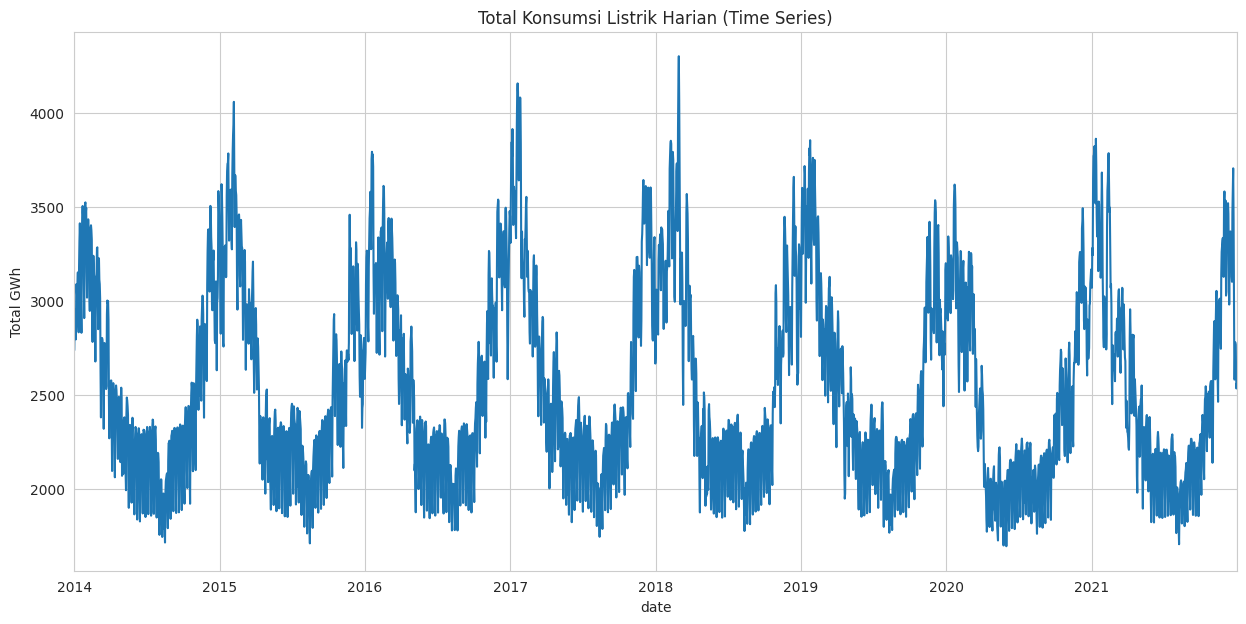

In [5]:
train_df.groupby('date')['electricity_consumption'].sum().plot(title='Total Konsumsi Listrik Harian (Time Series)')
plt.ylabel('Total GWh')
plt.show()

## Plot distribusi konsumsi listrik

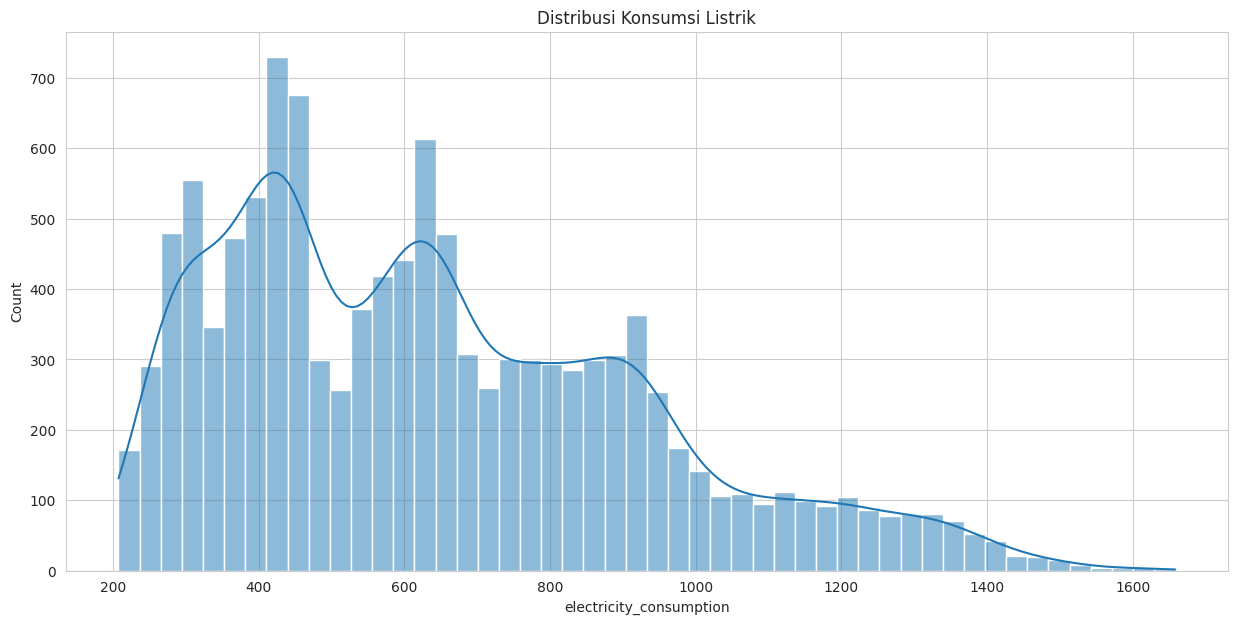

In [6]:
sns.histplot(train_df['electricity_consumption'], kde=True, bins=50)
plt.title('Distribusi Konsumsi Listrik')
plt.show()

## Plot konsumsi listrik per cluster

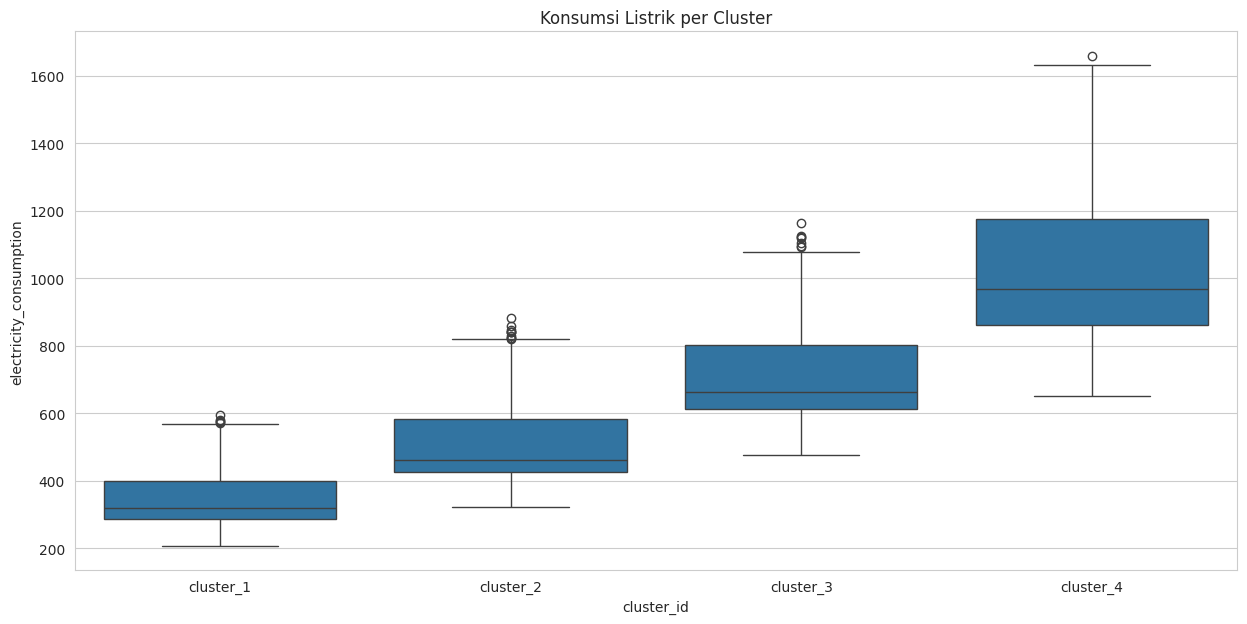

In [7]:
sns.boxplot(data=train_df, x='cluster_id', y='electricity_consumption')
plt.title('Konsumsi Listrik per Cluster')
plt.show()

## Plot korelasi fitur numerik

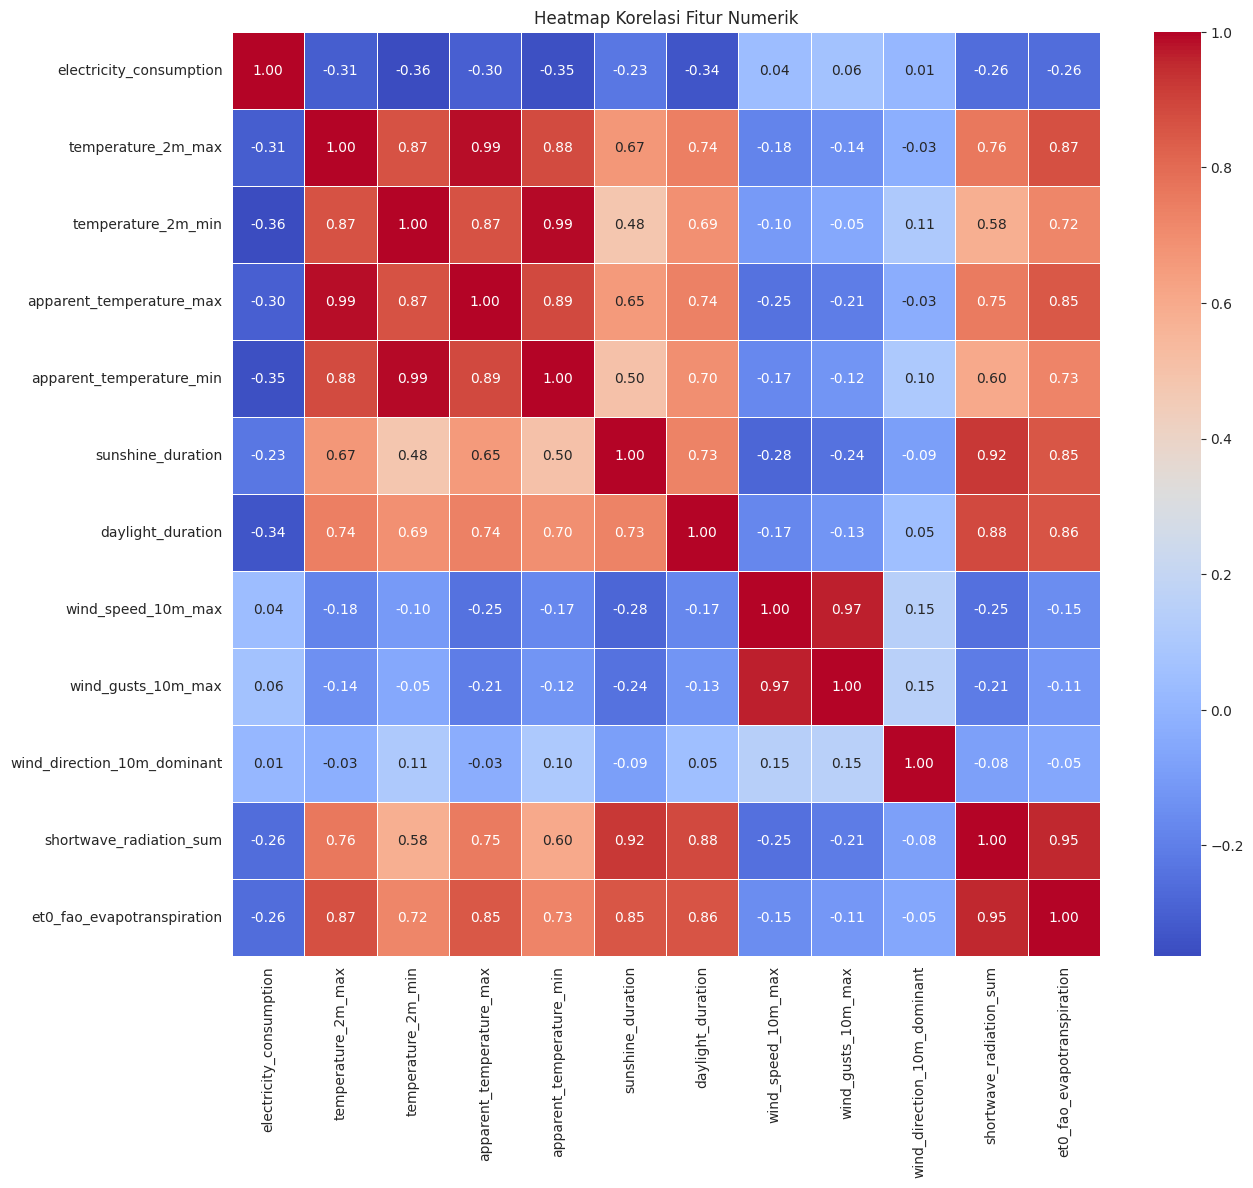

In [8]:
numeric_cols = train_df.select_dtypes(include=np.number).columns.tolist()
corr_matrix = train_df[numeric_cols].corr()

plt.figure(figsize=(14, 12))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title('Heatmap Korelasi Fitur Numerik')
plt.show()

# 4. DATA PREPROCESSING & FEATURE ENGINEERING

In [9]:
print("\n--- Memulai Preprocessing & Feature Engineering ---")

def create_features(df):
    """
    Membuat fitur dari data yang ada.
    """
    df_copy = df.copy()

    # Fitur berbasis waktu
    df_copy['year'] = df_copy['date'].dt.year
    df_copy['month'] = df_copy['date'].dt.month
    df_copy['day'] = df_copy['date'].dt.day
    df_copy['dayofweek'] = df_copy['date'].dt.dayofweek
    df_copy['weekofyear'] = df_copy['date'].dt.isocalendar().week.astype(int)
    df_copy['quarter'] = df_copy['date'].dt.quarter

    # Fitur berbasis cuaca
    df_copy['temp_range'] = df_copy['temperature_2m_max'] - df_copy['temperature_2m_min']
    df_copy['apparent_temp_range'] = df_copy['apparent_temperature_max'] - df_copy['apparent_temperature_min']
    df_copy['wind_chill_effect'] = df_copy['temperature_2m_max'] - df_copy['apparent_temperature_max']

    return df_copy


--- Memulai Preprocessing & Feature Engineering ---


## Terapkan pembuatan fitur


In [10]:
train_df = create_features(train_df)
test_df = create_features(test_df)

## One-Hot Encoding untuk 'cluster_id'


In [11]:
train_df = pd.get_dummies(train_df, columns=['cluster_id'], prefix='cluster')
test_df = pd.get_dummies(test_df, columns=['cluster_id'], prefix='cluster')

## Definisikan fitur dan target

In [12]:
features = [col for col in train_df.columns if col not in ['ID', 'date', 'electricity_consumption']]
target = 'electricity_consumption'

## Menyelaraskan kolom antara train dan test


In [13]:
train_labels = train_df[target]
train_ids = train_df['ID']
test_ids = test_df['ID']

X_train_df = train_df[features]
X_test_df = test_df.reindex(columns=X_train_df.columns, fill_value=0)

## Scaling Fitur Numerik

In [14]:
numeric_features = X_train_df.select_dtypes(include=np.number).columns.tolist()
scaler = StandardScaler()

## Fit scaler pada data train dan transform keduanya


In [15]:
X_train_df[numeric_features] = scaler.fit_transform(X_train_df[numeric_features])
X_test_df[numeric_features] = scaler.transform(X_test_df[numeric_features])

print("Data siap untuk pemodelan.")
print("Jumlah fitur:", len(features))
display(X_train_df.head())

Data siap untuk pemodelan.
Jumlah fitur: 24


,temperature_2m_max,temperature_2m_min,apparent_temperature_max,apparent_temperature_min,sunshine_duration,daylight_duration,wind_speed_10m_max,wind_gusts_10m_max,wind_direction_10m_dominant,shortwave_radiation_sum,...,dayofweek,weekofyear,quarter,temp_range,apparent_temp_range,wind_chill_effect,cluster_cluster_1,cluster_cluster_2,cluster_cluster_3,cluster_cluster_4
0,-1.057243,-0.499125,-1.289535,-0.603938,-2.150784,-1.538572,2.167752,2.152928,-0.162231,-1.524244,...,-0.500214,-1.701156,-1.350443,-1.308489,-1.717341,1.895716,True,False,False,False
1,-0.870672,-0.482346,-0.948310,-0.714131,-1.552039,-1.445631,1.592252,2.317124,-0.315258,-1.233425,...,-0.500214,-1.701156,-1.350443,-0.965441,-0.803701,1.043580,False,True,False,False
2,-0.777387,-1.338050,-0.783201,-1.333963,-0.955724,-1.348971,-0.296890,-0.139246,-0.425726,-1.167969,...,-0.500214,-1.701156,-1.350443,0.565079,0.601900,0.642575,False,False,True,False
3,-1.057243,-0.415232,-1.157448,-0.576390,-1.476364,-1.432826,1.429610,2.389370,-0.178719,-1.263737,...,-0.500214,-1.701156,-1.350443,-1.440430,-1.483075,1.294208,False,False,False,True
4,-1.070570,-0.029326,-1.168455,-0.204491,-0.509625,-1.531819,1.379567,1.890215,0.079428,-1.199598,...,0.000000,-1.701156,-1.350443,-2.073748,-2.139022,1.294208,True,False,False,False


# 5. MODEL, VALIDASI & HYPERPARAMETER TUNING

## Inisialisasi TimeSeriesSplit


In [16]:
tscv = TimeSeriesSplit(n_splits=5)


## Baseline Model: Ridge Regression

In [17]:
print("\n--- Mengevaluasi Baseline Model (Ridge) ---")
ridge = Ridge(alpha=1.0)
rmse_scores = []

for train_index, val_index in tscv.split(X_train_df):
    X_t, X_v = X_train_df.iloc[train_index], X_train_df.iloc[val_index]
    y_t, y_v = train_labels.iloc[train_index], train_labels.iloc[val_index]

    ridge.fit(X_t, y_t)
    preds = ridge.predict(X_v)
    rmse = np.sqrt(mean_squared_error(y_v, preds))
    rmse_scores.append(rmse)

print(f"Rata-rata RMSE Ridge (Baseline): {np.mean(rmse_scores):.4f}\n")


--- Mengevaluasi Baseline Model (Ridge) ---
Rata-rata RMSE Ridge (Baseline): 72.7172



## Model Utama: LightGBM dengan RandomizedSearchCV

### Definisikan model


In [18]:
lgbm = lgb.LGBMRegressor(random_state=42)


### Definisikan grid parameter untuk RandomizedSearchCV


In [19]:
param_dist = {
    'n_estimators': randint(300, 2000),
    'learning_rate': uniform(0.01, 0.05),
    'num_leaves': randint(31, 100),
    'max_depth': randint(7, 20),
    'subsample': uniform(0.6, 0.4),
    'colsample_bytree': uniform(0.6, 0.4),
    'reg_alpha': uniform(0, 1),
    'reg_lambda': uniform(0, 1),
}

### Inisialisasi RandomizedSearchCV


In [20]:
random_search = RandomizedSearchCV(
    estimator=lgbm,
    param_distributions=param_dist,
    n_iter=2,
    scoring='neg_root_mean_squared_error',
    cv=tscv,
    n_jobs=-1,
    random_state=42,
    verbose=1
)

### Lakukan fitting


In [21]:
random_search.fit(X_train_df, train_labels)


Fitting 5 folds for each of 2 candidates, totalling 10 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000706 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3688
[LightGBM] [Info] Number of data points in the train set: 11688, number of used features: 24
[LightGBM] [Info] Start training from score 642.313328


RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
                   estimator=LGBMRegressor(random_state=42), n_iter=2,
                   n_jobs=-1,
                   param_distributions={'colsample_bytree': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7bbf227d1a90>,
                                        'learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0...
                                        'num_leaves': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7bbf227b88d0>,
                                        'reg_alpha': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7bbf25323e10>,
                                        'reg_lambda': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7bbf233d4dd0>,
                                        'subsample': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7bbf227d3fd0>},
                   random_state=42, scoring='neg_root_mean_squared_error',
                   verbose=1)

### Tampilkan hasil terbaik


In [22]:
best_rmse = -random_search.best_score_
print(f"\nRMSE terbaik dari validasi silang: {best_rmse:.4f}")
print("Parameter terbaik:")
print(random_search.best_params_)


RMSE terbaik dari validasi silang: 35.5210
Parameter terbaik:
{'colsample_bytree': np.float64(0.7836995567863468), 'learning_rate': np.float64(0.026685430556951092), 'max_depth': 14, 'n_estimators': 1987, 'num_leaves': 33, 'reg_alpha': np.float64(0.020584494295802447), 'reg_lambda': np.float64(0.9699098521619943), 'subsample': np.float64(0.9329770563201687)}


# 6. INTERPRETASI MODEL & SUBMISSION

## Ambil model terbaik


In [23]:
best_lgbm = random_search.best_estimator_


## Feature Importance

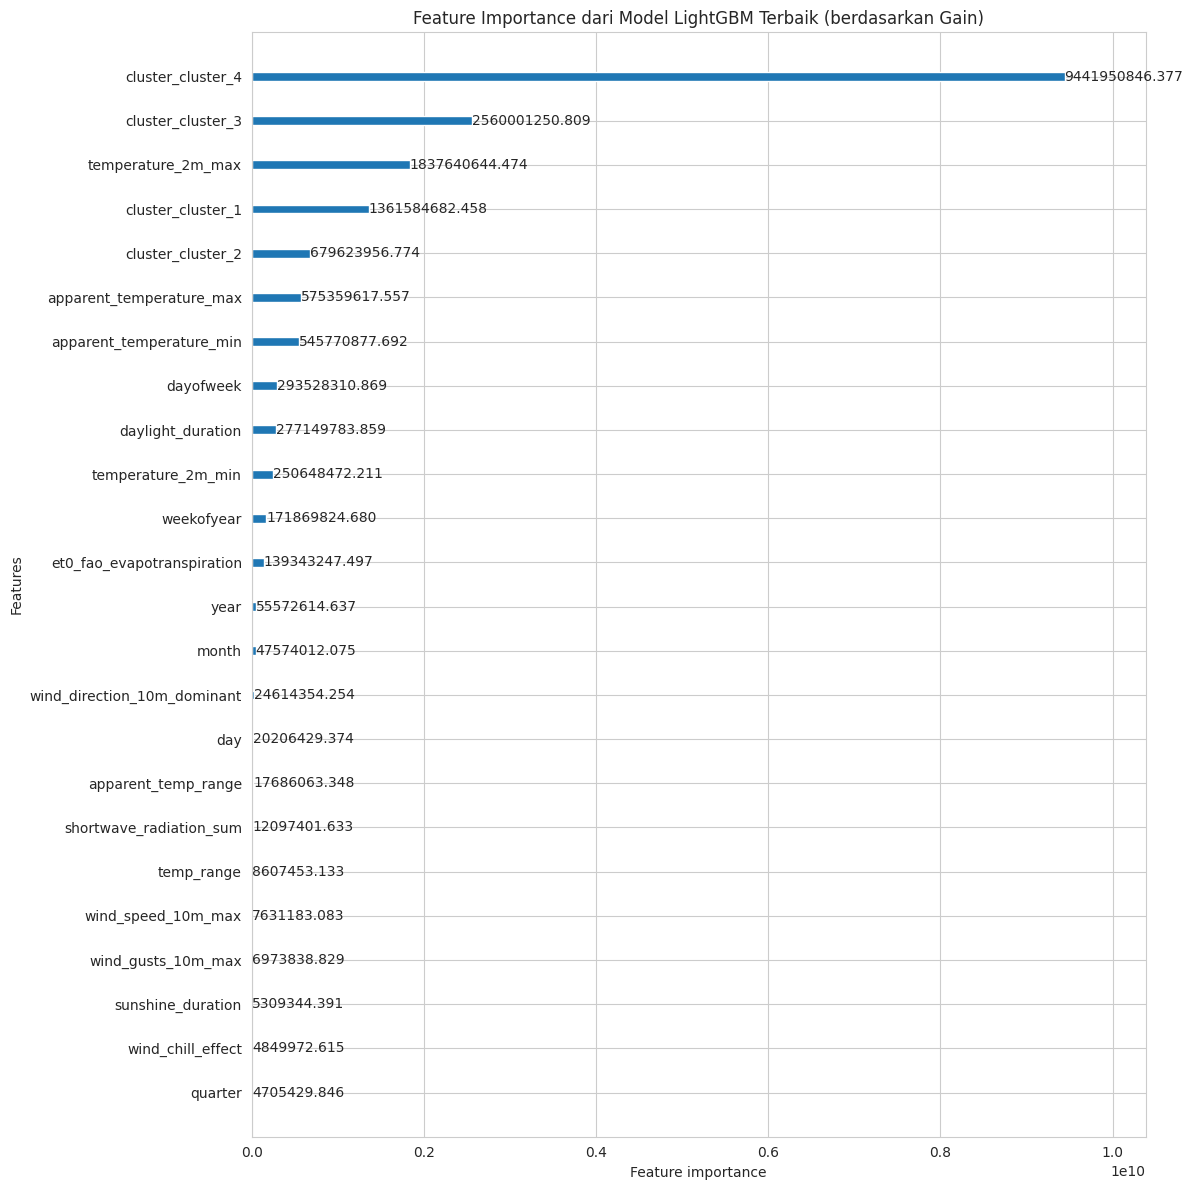

In [24]:
lgb.plot_importance(best_lgbm, figsize=(12, 12), max_num_features=30, importance_type='gain')
plt.title('Feature Importance dari Model LightGBM Terbaik (berdasarkan Gain)')
plt.tight_layout()
plt.show()

## Plot Residual (Prediksi vs Aktual) pada fold validasi terakhir

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002003 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3666
[LightGBM] [Info] Number of data points in the train set: 9740, number of used features: 24
[LightGBM] [Info] Start training from score 642.647817
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


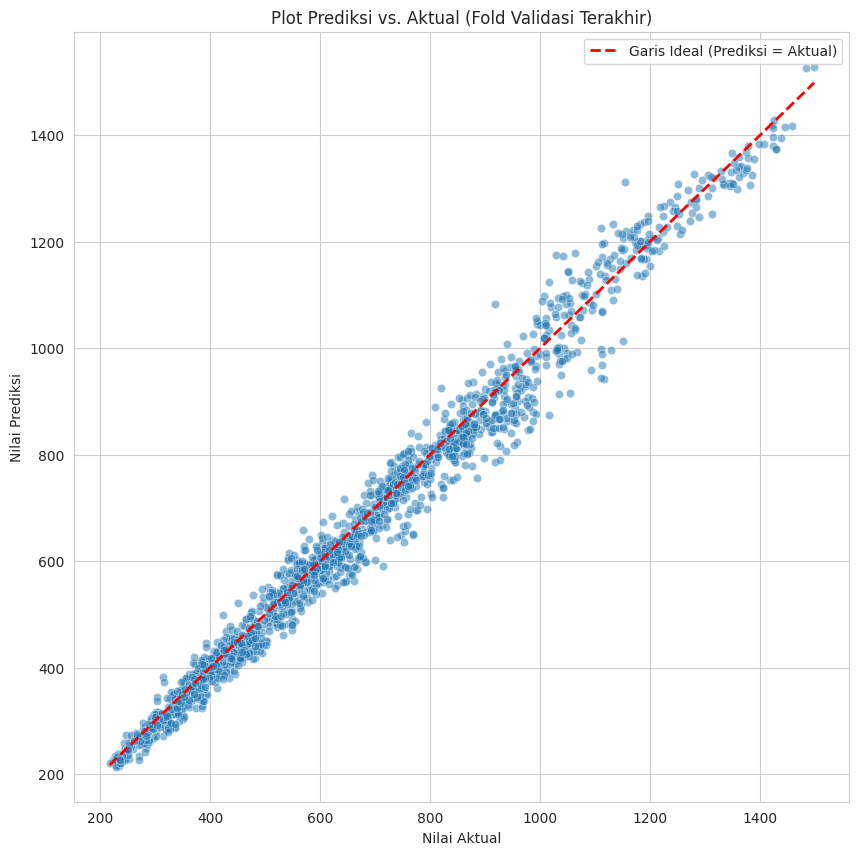

In [25]:
*_, (train_index, val_index) = tscv.split(X_train_df)
X_t, X_v = X_train_df.iloc[train_index], X_train_df.iloc[val_index]
y_t, y_v = train_labels.iloc[train_index], train_labels.iloc[val_index]

best_lgbm.fit(X_t, y_t)
val_preds = best_lgbm.predict(X_v)

plt.figure(figsize=(10, 10))
sns.scatterplot(x=y_v, y=val_preds, alpha=0.5)
plt.plot([y_v.min(), y_v.max()], [y_v.min(), y_v.max()], 'r--', lw=2, label='Garis Ideal (Prediksi = Aktual)')
plt.xlabel("Nilai Aktual")
plt.ylabel("Nilai Prediksi")
plt.title("Plot Prediksi vs. Aktual (Fold Validasi Terakhir)")
plt.legend()
plt.show()

## Final Training & Membuat File Submission

### Latih model terbaik pada seluruh data training


In [26]:
final_model = lgb.LGBMRegressor(random_state=42, **random_search.best_params_)
final_model.fit(X_train_df, train_labels)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004379 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3688
[LightGBM] [Info] Number of data points in the train set: 11688, number of used features: 24
[LightGBM] [Info] Start training from score 642.313328


LGBMRegressor(colsample_bytree=np.float64(0.7836995567863468),
              learning_rate=np.float64(0.026685430556951092), max_depth=14,
              n_estimators=1987, num_leaves=33, random_state=42,
              reg_alpha=np.float64(0.020584494295802447),
              reg_lambda=np.float64(0.9699098521619943),
              subsample=np.float64(0.9329770563201687))

### Lakukan prediksi pada data test


In [27]:
test_predictions = final_model.predict(X_test_df)


### Buat DataFrame submission


In [28]:
submission_df = pd.DataFrame({'ID': test_ids, 'electricity_consumption': test_predictions})


### Pastikan tidak ada nilai negatif


In [29]:
submission_df['electricity_consumption'] = submission_df['electricity_consumption'].clip(lower=0)


### Simpan ke file CSV


In [30]:
submission_df.to_csv('submission.csv', index=False)

print("\n" + "="*50)
print(f"Validation RMSE: {best_rmse:.4f}")
print("Submission file created: submission.csv")
print("="*50)
print("\nContoh file submission:")
display(submission_df.head())


Validation RMSE: 35.5210
Submission file created: submission.csv

Contoh file submission:


,ID,electricity_consumption
0,cluster_1_2022-01-01,294.925222
1,cluster_2_2022-01-01,459.305970
2,cluster_3_2022-01-01,650.318794
3,cluster_4_2022-01-01,964.558074
4,cluster_1_2022-01-02,338.302415
